# 1doc3 Data Science 

## Elaborado por : Juan David García Castro 

### Correo : juancastro97125@gmail.com

#### Fecha : 19 de Mayo de 2021

## En el presente documenta se presenta el desarrollo del proyecto de data science haciendo uso de la base de datos de productos. 

In [1]:
# Librerias 
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import missingno as msno 
import xgboost as xgb 
import gensim
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn import metrics
from bs4 import BeautifulSoup
from numpy import random
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# TAREA#1 : ANÁLISIS DE LOS DATOS

## En este aparatado se desarrollaron 3 procesos principalmente: lectura de los datos (train y val), limpieza de los datos y su posterior análisis exploratorio. 

In [2]:
productos_train = pd.read_csv('Train.csv', header=None, names = ['label','title','is_validated_by_human'], error_bad_lines=False,skiprows=1)
productos_train.head()
productos_val = pd.read_csv('Validation.csv', header=None, names = ['label','title','is_validated_by_human'], error_bad_lines=False,skiprows=1)
productos_val.head()


,label,title,is_validated_by_human
0,TABLETS,Noblex B10t - Pantalla 10.1 Con Windows 8 Casi...,YES;
1,TABLETS,Tablet 7 Pcbox Mdq Intel 1gb 8gb Wifi Camara 2...,YES;
2,"NOTEBOOKS,""Dell I5 7200 3,5ghz,8gb,ssd 256gb, ...",NaN,NaN
3,NOTEBOOKS,Hp 15-ay013la V7s33la I7 6500u 4gb Ram R7 M440...,YES;
4,"NOTEBOOKS,""Notebook Asus X541u Intel I5 7200u ...",NaN,NaN


In [3]:
print('El tamaño de la base de datos de entrenamiento es:',productos_train.shape)
print('El tamaño de la base de datos de validación es:',productos_val.shape)

El tamaño de la base de datos de entrenamiento es: (38705, 3)
El tamaño de la base de datos de validación es: (1245, 3)


In [4]:
productos_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   label                  38705 non-null  object
 1   title                  34442 non-null  object
 2   is_validated_by_human  34440 non-null  object
dtypes: object(3)
memory usage: 907.3+ KB


In [5]:
productos_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   label                  1245 non-null   object
 1   title                  1118 non-null   object
 2   is_validated_by_human  1118 non-null   object
dtypes: object(3)
memory usage: 29.3+ KB


##  A partir de la información anterior se evidencia que existen varios valores nulos dentro de las bases de  datos.

In [6]:
productos_train['label'].value_counts()

TELEPHONES                                                                         12928
CELLPHONES                                                                         10521
NOTEBOOKS                                                                           5707
TABLETS                                                                             5280
TABLETS,"iPad 3 64gb, Funciona Perfecto ,pero Tiene La Pantalla Rota",NO;;;            1
                                                                                   ...  
TELEPHONES,"iPhone 4s Libre De Fábrica, En Caja Original Con Cargador ",NO;;;          1
NOTEBOOKS,"Macbook Pro 13 A1278 2,5 Ghz Intel Core I5 4gb",NO;;;                       1
CELLPHONES,"Reiko Vertical Canvas Funda, Rugged Pouch Holster Metal Clip",NO;;;        1
CELLPHONES,"Fitkicks Weather And Sweat-resistant, Touchscreen Window Cel",NO;;;        1
NOTEBOOKS,"Msi Gt72vr Dominator 17.3 I7-6700 16gb Gtx1060, 256 Ssd+1tb",YES;;;         1
Name: label, Length: 

In [7]:
productos_train['title'].value_counts() 

NO";;                                                           2
Sony Xperia A1                                                  1
Telefono Inalambrico Philips M3301w Identificador Agenda 6.0    1
Motorcord Coche Monte Imán Uno - Tocar Aire Respiradero Tel     1
Hélice Ethwalbk 3- En Billetera Teléfono ( Negro )              1
                                                               ..
Notebook Lenovo V310-15isk I7 Freedos 12gb 1tb 80sy02cmar Tl    1
Asus Tablet Zenpad 3s 10 Z500m 4gb Ram 64gb Ips Silver          1
Notebook Rca B34i54500s Core I5 4gb 500gb Led 14 Wide Oferta    1
Telefono De Mesa O Pared Panacom Pa-7220 Para Colgar Pce        1
Samsung A30 32gb  Tarjetas/envios/garantia                      1
Name: title, Length: 34441, dtype: int64

In [8]:
productos_train['is_validated_by_human'].value_counts()

NO;;;     29156
YES;;;     5208
NO;;         55
NO;           6
YES;;         6
YES;          3
NO";;         2
NO            1
 4gb          1
YES";;        1
YES           1
Name: is_validated_by_human, dtype: int64

In [9]:
productos_val['label'].value_counts()

NOTEBOOKS                                                                        501
TABLETS                                                                          470
CELLPHONES                                                                       138
TELEPHONES                                                                         9
TABLETS,"Tablet 7 Rca,8gb,4core,proceador, Android 6, Bluetooh, Wifi",YES;         1
                                                                                ... 
NOTEBOOKS,"Notebook 15,6  Hp Pavillon A10 2.4ghz 16gb 1tb Video 4gb",YES;          1
TABLETS,"Tablet Gadnic 10,1 Dual Chip 3g 2gb + Funda Teclado",YES;                 1
NOTEBOOKS,"Hasee, Notabook De Juegos,i7700 Hk, 1060,256  Ssd,1t Hhd",YES;          1
NOTEBOOKS,"Permuto Men Val Notebook Acer Aspire, 500gb, 2ram, Amd E-350",YES;      1
NOTEBOOKS,"Notebook Hp Envy Core I7 6500, Disco 1 Tb,8gb, 15,6  Fullhd",YES;       1
Name: label, Length: 131, dtype: int64

In [10]:
productos_val['title'].value_counts()

Tablet Gadnic 4g - Funda Y Combo Nueva Con Touch Roto           1
2 Tablets Lenovo Tab 7 Essential 7304f 8gb Quad Core Android    1
Notebook Ultrabook Hp Envy 13 - I5 7ma Gen 8gb Ram 512 Ssd      1
Celular Blu Energy Xl 4g 3gb Ram 64 Rom Ultimas Unidades        1
Laptop Sony Vaio 17 Pulgadas Inc Deck                           1
                                                               ..
Notebook Hp 250 G6 Core I5 16gb 240 Ssd 15.6 Led Cuotas         1
Tablet 7 Performance Cx                                         1
Notebook Lenovo Ideapad 300 Intel Core I5-6200 2.3ghz 4gbram    1
Notebook 15.6  Intel Celeron 4gb+500gb S/s Kanji Novogar        1
Tablet Eurocase Tabi Eu-tb741 Personajes Mochila Auricular      1
Name: title, Length: 1118, dtype: int64

In [11]:
productos_val['is_validated_by_human'].value_counts()

YES;    1116
YES        2
Name: is_validated_by_human, dtype: int64

## En este punto se evidenció que en la columna 'label' contenía más datos de los necesarios y aquellos datos eran los que aparecían como nulos en las columnas de *title* y *is_validated_by_human*. A partir de ello, se procedió a desarrollar un método el cual tomara esos labels erróneos y los pasara a un formato adecuado con respecto a las otras dos columnas. 

In [12]:
bad_labels_train = []
for i in productos_train['label']:
    if len(i) > 10:
        bad_labels_train.append(i)

In [13]:
index = productos_train.index
for i in range(len(bad_labels_train)):
    condition = productos_train['label'] == bad_labels_train[i] 
    condition_indices = index[condition].tolist()
    indice = condition_indices[0]
    title = re.findall(r'"([^"]*)"', bad_labels_train[i])
    if len(title) >= 1:
        label_and_validated = bad_labels_train[i].replace(title[0] ,'')
        label_and_validated = label_and_validated.split(',')
        if len(label_and_validated) >2:
            productos_train.at[indice,'title']= title[0]
            productos_train.at[indice,'label']= label_and_validated[0]
            validated = label_and_validated[2]
            if 'YES' in validated:
                productos_train.at[indice,'is_validated_by_human'] = label_and_validated[2][0:3]
            elif  'NO' in validated:
                productos_train.at[indice,'is_validated_by_human'] = label_and_validated[2][0:2]
            elif validated == '4gb':
                productos_train.at[indice,'is_validated_by_human'] = 'YES'
        else:
            continue    
    else:
        continue  

In [14]:
 bad_labels_val = []
for i in productos_val['label']:
    if len(i) > 10:
        bad_labels_val.append(i)

In [15]:
index = productos_val.index
for i in range(len(bad_labels_val)):
    condition = productos_val['label'] == bad_labels_val[i] 
    condition_indices = index[condition].tolist()
    indice = condition_indices[0]
    title = re.findall(r'"([^"]*)"', bad_labels_val[i])
    if len(title) >= 1:
        label_and_validated = bad_labels_val[i].replace(title[0] ,'')
        label_and_validated = label_and_validated.split(',')
        if len(label_and_validated) >2:
            productos_val.at[indice,'title']= title[0]
            productos_val.at[indice,'label']= label_and_validated[0]
            validated = label_and_validated[2]
            if 'YES' in validated:
                productos_val.at[indice,'is_validated_by_human'] = label_and_validated[2][0:3]
            elif  'NO' in validated:
                productos_val.at[indice,'is_validated_by_human'] = label_and_validated[2][0:2]
            elif validated == '4gb':
                productos_val.at[indice,'is_validated_by_human'] = 'YES'
        else:
            continue    
    else:
        continue    

In [16]:
labels =[]
for label in productos_train['label']:
    l = label.split(',')[0]
    labels.append(l)
productos_train['labels'] = labels
productos_train['labels'].value_counts()

TELEPHONES    14037
CELLPHONES    12253
NOTEBOOKS      6615
TABLETS        5800
Name: labels, dtype: int64

In [17]:
labels =[]
for label in productos_val['label']:
    l = label.split(',')[0]
    labels.append(l)
productos_val['labels'] = labels
productos_val['labels'].value_counts()

NOTEBOOKS     583
TABLETS       512
CELLPHONES    141
TELEPHONES      9
Name: labels, dtype: int64

In [18]:
validated_mode = productos_train.is_validated_by_human.mode()[0]
productos_train.is_validated_by_human.fillna(validated_mode , inplace=True)

In [19]:
validated_mode = productos_val.is_validated_by_human.mode()[0]
productos_val.is_validated_by_human.fillna(validated_mode , inplace=True)

###  Para la columna de validación por humanos , tanto en *train* como en *validación*, los valores nulos se reemplazaron por la moda.

In [20]:
validateds = []
for val in productos_train['is_validated_by_human']:
    if 'NO' in val:
        validateds.append(val[0:2])
    elif 'YES' in val:
        validateds.append(val[0:3]) 
    elif  val == '4gb':
        validateds.append('YES')   

validateds.append('YES')
productos_train['is_validated_by_humans'] = validateds

In [21]:
validateds = []
for val in productos_val['is_validated_by_human']:
    if 'NO' in val:
        validateds.append(val[0:2])
    elif 'YES' in val:
        validateds.append(val[0:3]) 
    elif  val == '4gb':
        validateds.append('YES')   

productos_val['is_validated_by_humans'] = validateds

### En este paso se eliminaron las columnas antiguas y solo nos quedamos con las nuevas columnas que se generaron anteriormente en donde ya se tienen los datos limpios. 

In [22]:
productos_train.drop(columns = ['label'],axis=1,inplace=True)
productos_train.drop(columns= ['is_validated_by_human'],axis=1,inplace=True)
productos_val.drop(columns = ['label'],axis=1,inplace=True)
productos_val.drop(columns= ['is_validated_by_human'],axis=1,inplace=True)

### La siguiente función lleva a cabo una limpieza del texto de la columna 'title'. Esto se hace debido a que en dicha columna encontramos bastantes caracteres que no serán útiles para la representación final de los textos. 

In [23]:
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "html.parser").text 
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
productos_train['title'] = productos_train['title'].apply(clean_text)
productos_train = productos_train[productos_train['title'].notna()]

In [25]:
productos_val['title'] = productos_val['title'].apply(clean_text)

## ESTADÍSTICAS DE LOS DATOS 

In [26]:
# CANTIDAD DE VALORES NULOS 
print("la cantidad de valores nulos en el conjunto de entrenamiento son:", productos_train.isnull().sum())
print("la cantidad de valores nulos en el conjunto de validación son:", productos_val.isnull().sum())

la cantidad de valores nulos en el conjunto de entrenamiento son: title                     0
labels                    0
is_validated_by_humans    0
dtype: int64
la cantidad de valores nulos en el conjunto de validación son: title                     0
labels                    0
is_validated_by_humans    0
dtype: int64


### 1) Distribución de las anotaciones en los dos conjuntos de datos

Text(0.5, 1.0, 'Distribución del número de Anotaciones')

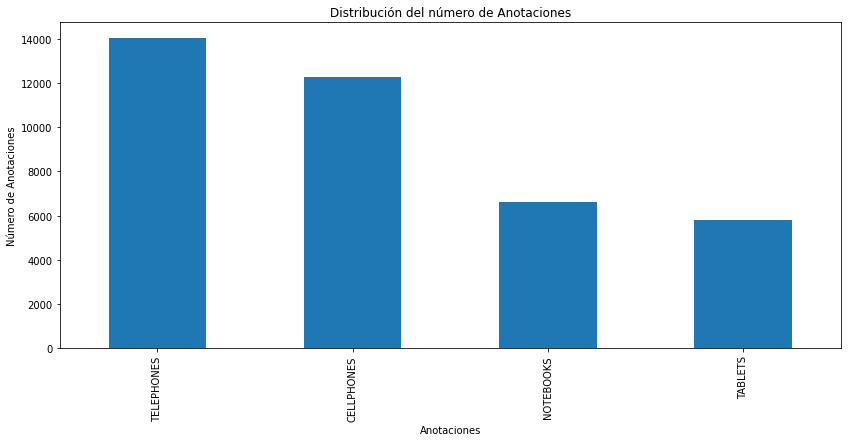

In [27]:
ax = productos_train['labels'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('Anotaciones')
ax.set_ylabel('Número de Anotaciones')
ax.set_title('Distribución del número de Anotaciones')

###  De la anterior gráfica se puede evidenciar que existe un mayor número de anotaciones de las clases *telephones* y *cellphones*. 

Text(0.5, 1.0, 'Distribución del número de Anotaciones')

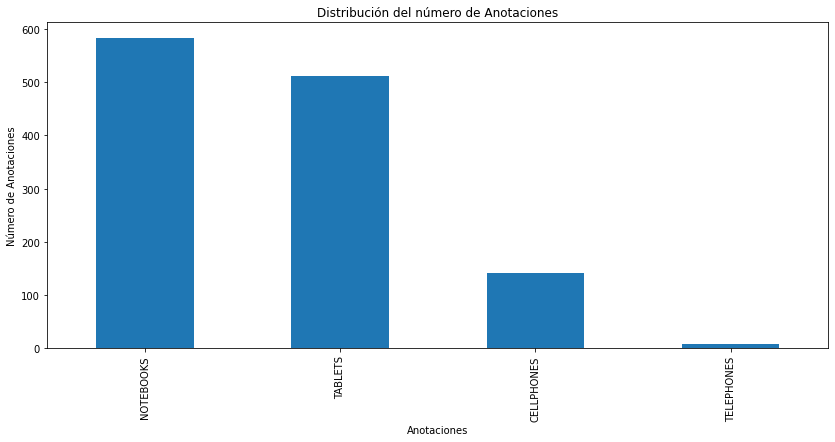

In [28]:
ax = productos_val['labels'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('Anotaciones')
ax.set_ylabel('Número de Anotaciones')
ax.set_title('Distribución del número de Anotaciones')


### 2) Distribución de la validación por humanos para los dos conjuntos de datos 

Text(0.5, 1.0, 'Distribución de las validaciones')

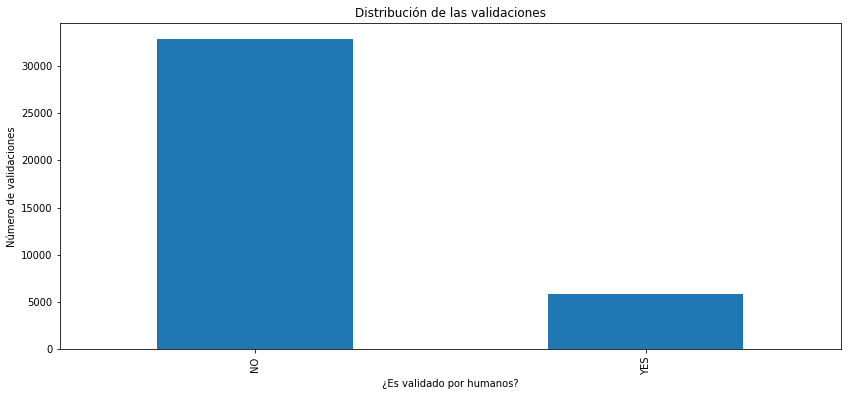

In [29]:
ax = productos_train['is_validated_by_humans'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('¿Es validado por humanos?')
ax.set_ylabel('Número de validaciones')
ax.set_title('Distribución de las validaciones')

Text(0.5, 1.0, 'Distribución de las validaciones')

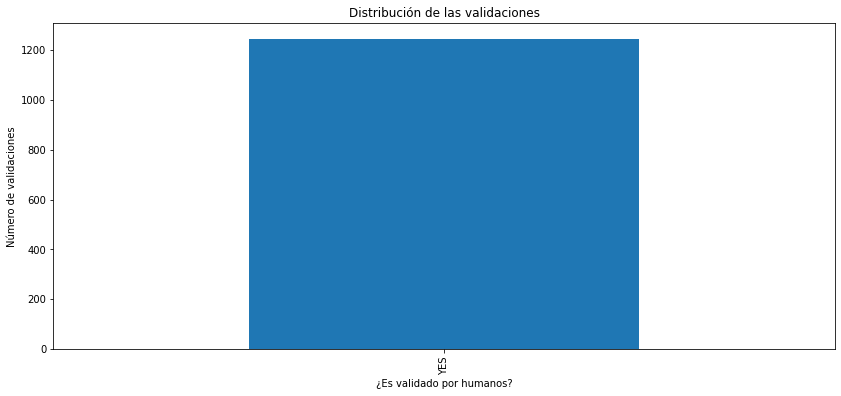

In [30]:
ax = productos_val['is_validated_by_humans'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('¿Es validado por humanos?')
ax.set_ylabel('Número de validaciones')
ax.set_title('Distribución de las validaciones')

### Por último y por facilidad de manejo de los datos se crearon dos archivos csv nuevos en los cuales ya se encuentran los datos limpios. 

In [31]:
productos_train.to_csv('new_train.csv', encoding='utf-8', index=False)

In [32]:
productos_val.to_csv('new_val.csv', encoding='utf-8', index=False)

# A PARTIR DE ESTE PUNTO SE TRABAJA CON LOS NUEVOS ARCHIVOS CSV 

In [33]:
train_data = pd.read_csv('new_train.csv')
train_data.head()

,title,labels,is_validated_by_humans
0,telfono inalambrico duo motorola m7002 + handy...,TELEPHONES,YES
1,acer aspire 7520 notebook 17 disco ssd + hdd d...,NOTEBOOKS,YES
2,tablet pc box 7 quad 1gb 8gb doble cam android 60,TABLETS,YES
3,notebook hp x360 156 intel i5 1tb 8gb win10 to...,NOTEBOOKS,YES
4,notebook hp 240 g5 freedos core i3 dvd hdmi 4g...,NOTEBOOKS,YES


In [34]:
val_data = pd.read_csv('new_val.csv')
val_data.head() 

,title,labels,is_validated_by_humans
0,noblex b10t pantalla 101 windows 8 casi nueva,TABLETS,YES
1,tablet 7 pcbox mdq intel 1gb 8gb wifi camara 2...,TABLETS,YES
2,dell i5 7200 3 5ghz 8gb ssd 256gb 15 6 pantall...,NOTEBOOKS,YES
3,hp 15ay013la v7s33la i7 6500u 4gb ram r7 m440 ...,NOTEBOOKS,YES
4,notebook asus x541u intel i5 7200u 8gb hd 1tb ...,NOTEBOOKS,YES


In [ ]:
#%% UN PEQUEÑO MÉTODO PARA LA MATRIZ DE CONFUSIÓN 
col = ['labels','title']
train_data = train_data[col]
train_data.columns = ['labels','title']
train_data['labels_id'] = train_data['labels'].factorize()[0] # pasamos los labels a números del 0 al 3 

labels_id_train_data = train_data[['labels','labels_id']].drop_duplicates().sort_values('labels_id')
labels_to_id = dict(labels_id_train_data.values)
id_to_labels = dict(labels_id_train_data[['labels_id','labels']].values)

# ENTRENAMIENTO DE LOS MODELOS. 

### Se utilizaron diferentes modelos para la clasificación de los títulos de los productos. Los modelos más usados según la literatura para abordar este problema son:

1. Naive Bayes Multinomial.
2. Regresión Logística.
3. Clasificador con descenso del gradiente. 
4. XGBOOST

### A continuación se presentan las métricas obtenidas por los modelos y su posterior análisis. 




In [ ]:
X_train = train_data['title']
y_train = train_data['labels']
X_test = val_data['title']
y_test = val_data['labels']

## NAIVE BAYES MULTINOMIAL 

In [ ]:
# Entrenamiento del modelo.
nb = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de XGBOOST  VECTORIZER es:",metrics.accuracy_score(y_test, y_pred))

y_prob = nb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## REGRESIÓN LOGÍSTICA 

In [ ]:
# Entrenamiento del modelo.
logreg = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', LogisticRegression(n_jobs=1, C=1e5)),
              ])

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística es:",metrics.accuracy_score(y_test, y_pred))

y_prob = logreg.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Clasificador con descenso del gradiente

In [ ]:
# Entrenamiento del modelo.
sgd  = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])

sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso del clasificador con descenso del gradiente es:",metrics.accuracy_score(y_test, y_pred))

y_prob = sgd.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## XGBOOST 

In [ ]:
# Entrenamiento del modelo.
clf_xgb = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', XGBClassifier( random_state=42,objective = 'reg:logistic',learn_rate = 0.05, gamma = 0.25, max_depth = 5, reg_lambda = 1, scale_pos_weight = 3, seed=2, colsample_bytree=0.6, subsample=0.7)),
              ])

clf_xgb.fit(X_train, y_train,clf__verbose = True,clf__eval_metric = 'aucpr')

y_pred = clf_xgb.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de XGBOOST es:",metrics.accuracy_score(y_test, y_pred))

y_prob = clf_xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))